In [1]:
import os
import sys
import math
import argparse
import numpy as np
from collections import Counter

# Keras imports
from keras.models import Model
from keras import backend as K
from sklearn.manifold import TSNE

# ML4CVD Imports
sys.path.append("../ml4cvd")
from arguments import parse_args
from tensor_generators import test_train_valid_tensor_generators
from recipes import train_shallow_model, train_multimodal_multitask, test_multimodal_multitask
from models import make_multimodal_to_multilabel_model, train_model_from_generators, make_shallow_model, make_hidden_layer_model

# IPython imports
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sys.argv = ['train_shallow', 
            '--tensors', '/mnt/disks/survey-tensors2/2019-03-25/', 
            '--input_tensors', 'categorical-phenotypes-965', 
            '--output_tensors', 'allergic_rhinitis', 'anxiety', 'asthma', 'atrial_fibrillation_or_flutter', 'back_pain', 
            'breast_cancer', 'cardiac_surgery', 'cervical_cancer', 'colorectal_cancer', 'coronary_artery_disease_hard', 
            'coronary_artery_disease_intermediate', 'coronary_artery_disease_soft', 'death', 'diabetes_all', 
            'diabetes_type_1', 'diabetes_type_2', 'enlarged_prostate', 'heart_failure', 'hypertension', 'lung_cancer', 
            'migraine', 'myocardial_infarction', 'osteoporosis', 'skin_cancer', 'stroke',
            '--model_file', '/mnt/ml4cvd/projects/jamesp/data/models/shallow_cat965.hd5',
            '--id', 'shallow_cat965',
            '--epochs', '1',
            '--test_steps', '2',
            '--batch_size', '128',
            '--training_steps', '2',
            '--validation_steps', '1']

args = parse_args()
m = make_shallow_model(args.tensor_maps_in, args.tensor_maps_out, args.learning_rate, args.model_file, args.model_layers)
rev_cm =  dict((v,k) for k,v in args.tensor_maps_in[0].channel_map.items())

2019-04-30 20:09:48,579 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/shallow_cat965/log_2019-04-30_20-09_0.log.
2019-04-30 20:09:48,580 - arguments:231 - INFO - Total TensorMaps:885 Arguments are Namespace(activation='relu', aligned_dimension=16, app_csv='/mnt/disks/data/raw/tsvs/ukb_app17488_app7089_link.csv', b_slice_force=None, balance_by_icds=[], batch_size=128, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[54, 924, 943, 971, 981, 1011, 1100, 1239, 1249, 1259, 1329, 1339, 1349, 1359, 1369, 1379, 1389, 1408, 1418, 1428, 1448, 1468, 1478, 1508, 1518, 1528, 1538, 1548, 1558, 1618, 1628, 1647, 1677, 1687, 1697, 1707, 1717, 1727, 1747, 1757, 1767, 1777, 1787, 1797, 1835, 2178, 2188, 2207, 2247, 2316, 2306, 2415, 2443, 2453, 2463, 2473, 2674, 2694, 2724, 2784, 2814, 2877, 3079, 3616, 3637, 3773,

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


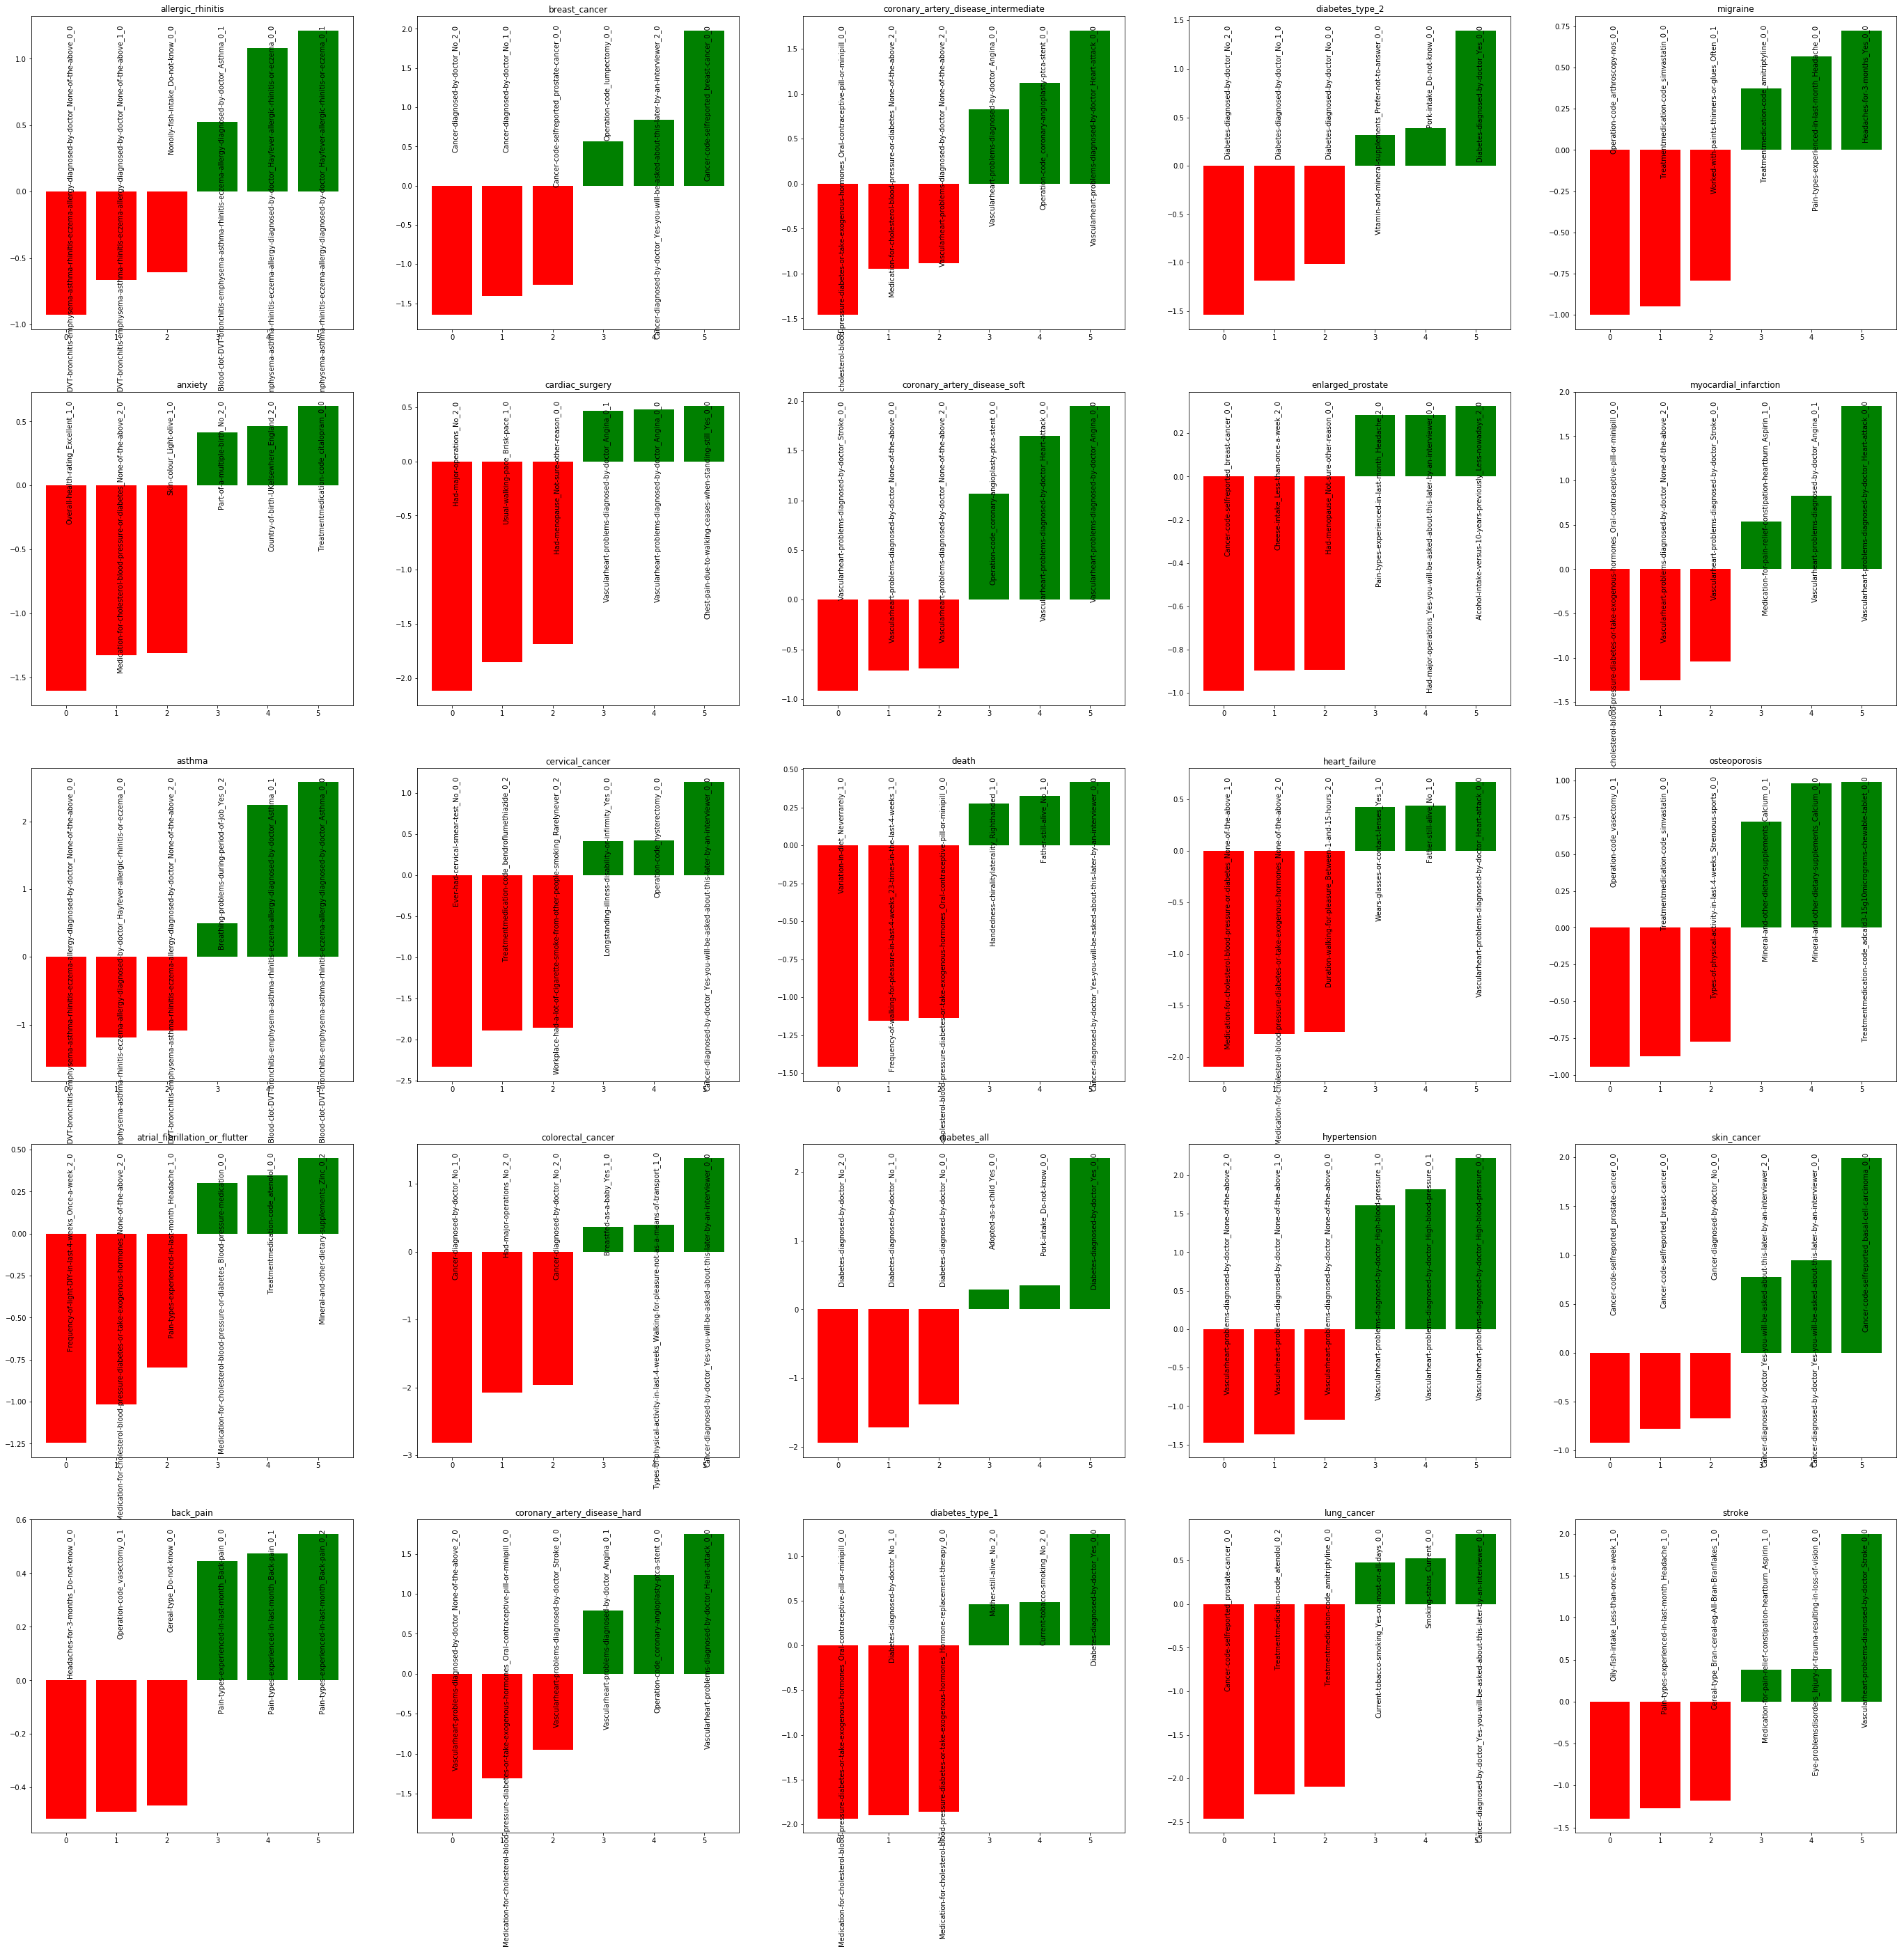

In [33]:
row = 0
col = 0
top_k = 3
text_limit = 64
total_plots = len(args.tensor_maps_out)
rows = max(2, int(math.sqrt(total_plots)))
cols = max(2, total_plots // rows)
fig, axes = plt.subplots(rows, cols, figsize=(48, 48))

for tm in args.tensor_maps_out:
    bar_vals = []
    bar_ticks = []
    bar_colors = []
    #print('\n\n~~~~~~~~~~~~~~~ Looking at TM: ', tm.output_name(), ' ~~~~~~~~~~~~~~~~~~')
    d1 = m.get_layer(tm.output_name())
    w1 = d1.get_weights()
    text_x = 0
    text_y = np.max(w1[0][:,1])
    for idx in np.argsort(w1[0][:,1])[:top_k]:
        axes[row,col].text(text_x, text_y, rev_cm[idx], rotation=90)
        bar_vals.append(w1[0][:,1][idx])
        bar_colors.append('red')
        text_x += 1
    for idx in np.argsort(w1[0][:,1])[-top_k:]:
        axes[row,col].text(text_x, text_y, rev_cm[idx], rotation=90)
        bar_vals.append(w1[0][:,1][idx])
        bar_colors.append('green')
        text_x += 1
    axes[row,col].bar(list(range(len(bar_vals))), bar_vals, color=bar_colors)
    axes[row,col].set_title(tm.name)
    #print('bt:', bar_ticks)
    row += 1
    if row == rows:
        row = 0
        col += 1
        if col >= cols:
            break
fig.show()

In [3]:
for tm in args.tensor_maps_out:
    print('\n\n~~~~~~~~~~~~~~~ Looking at TM: ', tm.output_name(), ' ~~~~~~~~~~~~~~~~~~')
    d1 = m.get_layer(tm.output_name())
    w1 = d1.get_weights()
    for i in np.argsort(w1[0][:,1])[::-1]:
        sign = '+' if w1[0][i,1] > 0 else '-'
        print(sign+rev_cm[i])



~~~~~~~~~~~~~~~ Looking at TM:  output_allergic_rhinitis_categorical_index  ~~~~~~~~~~~~~~~~~~
+Blood-clot-DVT-bronchitis-emphysema-asthma-rhinitis-eczema-allergy-diagnosed-by-doctor_Hayfever-allergic-rhinitis-or-eczema_0_1
+Blood-clot-DVT-bronchitis-emphysema-asthma-rhinitis-eczema-allergy-diagnosed-by-doctor_Hayfever-allergic-rhinitis-or-eczema_0_0
+Blood-clot-DVT-bronchitis-emphysema-asthma-rhinitis-eczema-allergy-diagnosed-by-doctor_Asthma_0_1
+Blood-clot-DVT-bronchitis-emphysema-asthma-rhinitis-eczema-allergy-diagnosed-by-doctor_Hayfever-allergic-rhinitis-or-eczema_2_0
+Treatmentmedication-code_Freetext-entry-unable-to-be-coded_0_1
+Types-of-physical-activity-in-last-4-weeks_Heavy-DIY-eg-weeding-lawn-mowing-carpentry-digging_2_1
+Operation-code_nasalsinusnose-surgery_0_1
+Treatmentmedication-code_ibuprofen_0_2
+Operation-code_tonsillectomy-adenoids_0_0
+Operation-code_nasalsinusnose-surgery_0_0
+Operation-code_dilatation-and-curettagedc_0_3
+Operation-code_colonoscopysigmoidosco

+Treatmentmedication-code_citalopram_0_0
+Country-of-birth-UKelsewhere_England_2_0
+Part-of-a-multiple-birth_No_2_0
+Longstanding-illness-disability-or-infirmity_Yes_1_0
+Major-dietary-changes-in-the-last-5-years_Yes-because-of-other-reasons_1_0
+Longstanding-illness-disability-or-infirmity_Yes_2_0
+Bread-type_Wholemeal-or-wholegrain_1_0
+Maternal-smoking-around-birth_No_2_0
+Breastfed-as-a-baby_Yes_2_0
+Cancer-diagnosed-by-doctor_No_1_0
+Mineral-and-other-dietary-supplements_None-of-the-above_1_0
+Adopted-as-a-child_No_1_0
+Hot-drink-temperature_Hot_1_0
+Major-dietary-changes-in-the-last-5-years_No_2_0
+Chest-pain-felt-during-physical-activity_No_1_0
+Handedness-chiralitylaterality_Righthanded_2_0
+Weight-change-compared-with-1-year-ago_Yes-gained-weight_1_0
+Diabetes-diagnosed-by-doctor_No_2_0
+Milk-type-used_Semiskimmed_2_0
+Frequency-of-other-exercises-in-last-4-weeks_23-times-a-week_2_0
+Pacemaker_No_1_0
+Adopted-as-a-child_No_2_0
+Breathing-problems-during-period-of-job_Yes_0_1
+

~~~~~~~~~~~~~~~ Looking at TM:  output_atrial_fibrillation_or_flutter_categorical_index  ~~~~~~~~~~~~~~~~~~
+Mineral-and-other-dietary-supplements_Zinc_0_2
+Treatmentmedication-code_atenolol_0_0
+Medication-for-cholesterol-blood-pressure-or-diabetes_Blood-pressure-medication_0_0
+Treatmentmedication-code_allopurinol_0_0
+Frequency-of-other-exercises-in-last-4-weeks_Every-day_0_0
+Workplace-had-a-lot-of-diesel-exhaust_Sometimes_0_2
+Comparative-body-size-at-age-10_Do-not-know_0_0
+Medication-for-pain-relief-constipation-heartburn_Laxatives-eg-Dulcolax-Senokot_0_1
+Handedness-chiralitylaterality_Righthanded_1_0
+Wears-glasses-or-contact-lenses_Yes_1_0
+Workplace-very-dusty_Often_0_2
+Chest-pain-due-to-walking-ceases-when-standing-still_Yes_0_0
+Wears-glasses-or-contact-lenses_Yes_2_0
+Longstanding-illness-disability-or-infirmity_Yes_2_0
+Types-of-transport-used-excluding-work_Carmotor-vehicle_2_0
+Blood-clot-DVT-bronchitis-emphysema-asthma-rhinitis-eczema-allergy-diagnosed-by-doctor_Bloo

-FI1-numeric-addition-test_15_2_0
-Worked-with-pesticides_Rarelynever_0_1
-Poultry-intake_Less-than-once-a-week_0_0
-Vitamin-and-mineral-supplements_Multivitamins-minerals_0_0
-Nonoily-fish-intake_24-times-a-week_1_0
-UK-Biobank-assessment-centre_Reading_0_0
-Workplace-had-a-lot-of-cigarette-smoke-from-other-people-smoking_Rarelynever_0_4
-Operation-code_musclesoft-tissue-surgery_0_0
-Mouthteeth-dental-problems_Dentures_0_0
-Frequency-of-stair-climbing-in-last-4-weeks_610-times-a-day_2_0
-Hearing-difficultyproblems_Do-not-know_0_0
-Smoking-status_Never_2_0
-Treatmentmedication-code_allopurinol_0_0
-Diabetes-diagnosed-by-doctor_No_1_0
-UK-Biobank-assessment-centre_Edinburgh_0_0
-Treatmentmedication-code_atorvastatin_0_1
-Blood-clot-DVT-bronchitis-emphysema-asthma-rhinitis-eczema-allergy-diagnosed-by-doctor_Asthma_0_0
-Workplace-had-a-lot-of-cigarette-smoke-from-other-people-smoking_Sometimes_0_2
-FI7-synonym_Cease_0_0
-Nonoily-fish-intake_Never_0_0
-Types-of-physical-activity-in-last-4-

+Chest-pain-due-to-walking-ceases-when-standing-still_Yes_0_0
+Vascularheart-problems-diagnosed-by-doctor_Angina_0_0
+Vascularheart-problems-diagnosed-by-doctor_Angina_0_1
+Vascularheart-problems-diagnosed-by-doctor_Heart-attack_0_0
+Pacemaker_No_1_0
+Diabetes-diagnosed-by-doctor_No_1_0
+Smokingsmokers-in-household_No_1_0
+Able-to-walk-or-cycle-unaided-for-10-minutes_Yes_1_0
+Smokingsmokers-in-household_No_2_0
+Had-major-operations_Yes-you-will-be-asked-about-this-later-by-an-interviewer_2_0
+Mother-still-alive_No_2_0
+Eye-problemsdisorders_None-of-the-above_2_0
+Workplace-had-a-lot-of-diesel-exhaust_Sometimes_0_2
+Handedness-chiralitylaterality_Righthanded_1_0
+Drive-faster-than-motorway-speed-limit_Prefer-not-to-answer_0_0
+Treatmentmedication-code_ramipril_0_2
+Diabetes-diagnosed-by-doctor_No_2_0
+Comparative-body-size-at-age-10_Do-not-know_0_0
+Workplace-had-a-lot-of-diesel-exhaust_Sometimes_0_1
+Country-of-birth-UKelsewhere_Elsewhere_0_0
+Salt-added-to-food_Neverrarely_2_0
+Drive-

+Cancer-diagnosed-by-doctor_Yes-you-will-be-asked-about-this-later-by-an-interviewer_0_0
+Types-of-physical-activity-in-last-4-weeks_Walking-for-pleasure-not-as-a-means-of-transport_1_0
+Breastfed-as-a-baby_Yes_1_0
+Wheeze-or-whistling-in-the-chest-in-last-year_No_1_0
+Adopted-as-a-child_No_2_0
+Mother-still-alive_No_1_0
+Smoking-status_Previous_1_0
+Major-dietary-changes-in-the-last-5-years_Yes-because-of-illness_0_0
+Adopted-as-a-child_No_1_0
+Current-tobacco-smoking_No_2_0
+Smokingsmokers-in-household_No_2_0
+Smoking-status_Never_2_0
+Drive-faster-than-motorway-speed-limit_Sometimes_2_0
+Handedness-chiralitylaterality_Righthanded_2_0
+Fracturedbroken-bones-in-last-5-years_No_1_0
+Chest-pain-felt-during-physical-activity_No_1_0
+Eye-problemsdisorders_None-of-the-above_2_0
+Medication-for-pain-relief-constipation-heartburn_Paracetamol_0_1
+Wheeze-or-whistling-in-the-chest-in-last-year_No_2_0
+Lambmutton-intake_Less-than-once-a-week_2_0
+Longstanding-illness-disability-or-infirmity_Yes

-Operation-code_colonoscopysigmoidoscopy_0_2
-Medication-for-cholesterol-blood-pressure-or-diabetes_None-of-the-above_1_0
-Treatmentmedication-code_citalopram_0_0
-Beef-intake_Once-a-week_1_0
-Treatmentmedication-code_levothyroxine-sodium_0_0
-Operation-code_vasectomy_0_0
-Pain-types-experienced-in-last-month_Headache_2_0
-Worked-with-materials-containing-asbestos_Do-not-know_0_3
-Operation-code_arthroscopy-nos_0_0
-Cereal-type_Do-not-know_0_0
-Type-of-tobacco-previously-smoked_Handrolled-cigarettes_0_0
-Types-of-transport-used-excluding-work_Cycle_0_1
-Knee-pain-for-3-months_Yes_2_0
-Medication-for-cholesterol-blood-pressure-diabetes-or-take-exogenous-hormones_None-of-the-above_0_0
-Mother-still-alive_Yes_1_0
-Treatmentmedication-code_bendroflumethiazide_0_2
-Operation-code_sterilisation_0_0
-Hot-drink-temperature_Warm_2_0
-Operation-code_dilatation-and-curettagedc_0_2
-Treatmentmedication-code_levothyroxine-sodium_0_1
-Treatmentmedication-code_adcald3-15g10micrograms-chewable-tablet_

-Mineral-and-other-dietary-supplements_Iron_0_0
-Alcohol-intake-frequency_Special-occasions-only_0_0
-Pain-types-experienced-in-last-month_None-of-the-above_0_0
-Ever-taken-oral-contraceptive-pill_No_0_0
-Fracturedbroken-bones-in-last-5-years_No_1_0
-Cereal-type_Muesli_0_0
-Poultry-intake_Once-a-week_1_0
-Frequency-of-light-DIY-in-last-4-weeks_23-times-in-the-last-4-weeks_0_0
-Pain-types-experienced-in-last-month_Headache_1_0
-Cereal-type_Oat-cereal-eg-Ready-Brek-porridge_1_0
-Frequency-of-other-exercises-in-last-4-weeks_23-times-in-the-last-4-weeks_0_0
-Pain-types-experienced-in-last-month_Hip-pain_0_1
-UK-Biobank-assessment-centre_Cardiff_0_0
-Breathing-problems-during-period-of-job_No_0_8
-Frequency-of-stair-climbing-in-last-4-weeks_1620-times-a-day_0_0
-Breathing-problems-during-period-of-job_No_0_2
-FI1-numeric-addition-test_15_2_0
-Treatmentmedication-code_simvastatin_0_4
-Frequency-of-walking-for-pleasure-in-last-4-weeks_45-times-a-week_0_0
-Skin-colour_Light-olive_0_0
-Mouthtee

+Diabetes-diagnosed-by-doctor_Yes_0_0
+Pork-intake_Do-not-know_0_0
+Adopted-as-a-child_Yes_0_0
+Vitamin-and-mineral-supplements_Multivitamins-minerals_0_2
+Salt-added-to-food_Neverrarely_2_0
+Vitamin-and-mineral-supplements_Prefer-not-to-answer_0_0
+Longstanding-illness-disability-or-infirmity_Yes_2_0
+Types-of-physical-activity-in-last-4-weeks_Heavy-DIY-eg-weeding-lawn-mowing-carpentry-digging_2_1
+Vitamin-and-mineral-supplements_None-of-the-above_2_0
+Operation-code_cholecystectomygall-bladder-removal_0_1
+Other-serious-medical-conditiondisability-diagnosed-by-doctor_No_2_0
+Treatmentmedication-code_Freetext-entry-unable-to-be-coded_0_0
+Skin-colour_Fair_2_0
+Pain-types-experienced-in-last-month_Hip-pain_0_0
+Treatmentmedication-code_allopurinol_0_0
+Pain-types-experienced-in-last-month_None-of-the-above_1_0
+Adopted-as-a-child_No_2_0
+Operation-code_cholecystectomygall-bladder-removal_0_0
+Current-tobacco-smoking_No_1_0
+Mouthteeth-dental-problems_Toothache_0_2
+Cereal-type_Other-eg

-Why-stopped-smoking_Financial-reasons_0_1
-Worked-with-materials-containing-asbestos_Sometimes_0_1
-Medication-for-pain-relief-constipation-heartburn_Ibuprofen-eg-Nurofen_0_1
-Variation-in-diet_Neverrarely_1_0
-Medication-for-pain-relief-constipation-heartburn_Laxatives-eg-Dulcolax-Senokot_0_0
-Medication-for-cholesterol-blood-pressure-diabetes-or-take-exogenous-hormones_None-of-the-above_1_0
-Cheese-intake_Never_0_0
-Longstanding-illness-disability-or-infirmity_Do-not-know_0_0
-Workplace-very-dusty_Sometimes_0_2
-Workplace-had-a-lot-of-diesel-exhaust_Sometimes_0_1
-Hair-colour-natural-before-greying_Dark-brown_1_0
-Knee-pain-for-3-months_Yes_2_0
-Ever-used-hormonereplacement-therapy-HRT_Yes_1_0
-Operation-code_nasalsinusnose-surgery_0_0
-Treatmentmedication-code_atenolol_0_1
-Medication-for-cholesterol-blood-pressure-or-diabetes_None-of-the-above_0_0
-Beef-intake_Do-not-know_0_0
-Mineral-and-other-dietary-supplements_Zinc_0_2
-Operation-code_hip-replacementrevision_0_0
-Processed-mea

+Alcohol-intake-versus-10-years-previously_Less-nowadays_2_0
+Had-major-operations_Yes-you-will-be-asked-about-this-later-by-an-interviewer_0_0
+Pain-types-experienced-in-last-month_Headache_2_0
+Oily-fish-intake_Less-than-once-a-week_2_0
+Breathing-problems-during-period-of-job_Yes_0_1
+Types-of-physical-activity-in-last-4-weeks_Walking-for-pleasure-not-as-a-means-of-transport_2_0
+Operation-code_inguinalfemoral-hernia-repair_0_1
+Poultry-intake_Once-a-week_1_0
+Frequency-of-walking-for-pleasure-in-last-4-weeks_23-times-a-week_1_0
+Oily-fish-intake_Less-than-once-a-week_1_0
+Ease-of-skin-tanning_Get-mildly-or-occasionally-tanned_2_0
+Country-of-birth-UKelsewhere_England_2_0
+Current-tobacco-smoking_No_2_0
+Diabetes-diagnosed-by-doctor_No_2_0
+Father-still-alive_No_1_0
+Types-of-physical-activity-in-last-4-weeks_Light-DIY-eg-pruning-watering-the-lawn_2_2
+Cereal-type_Bran-cereal-eg-All-Bran-Branflakes_1_0
+Adopted-as-a-child_No_2_0
+Bread-type_Wholemeal-or-wholegrain_2_0
+Breastfed-as-

-Hot-drink-temperature_Warm_2_0
-Alcohol-intake-frequency_Once-or-twice-a-week_2_0
-Treatmentmedication-code_multivitamins_0_2
-Types-of-physical-activity-in-last-4-weeks_Heavy-DIY-eg-weeding-lawn-mowing-carpentry-digging_2_2
-Medication-for-cholesterol-blood-pressure-or-diabetes_None-of-the-above_2_0
-Pork-intake_Once-a-week_2_0
-Medication-for-cholesterol-blood-pressure-diabetes-or-take-exogenous-hormones_None-of-the-above_1_0
-Processed-meat-intake_Once-a-week_2_0
-Nonoily-fish-intake_Do-not-know_0_0
-Frequency-of-walking-for-pleasure-in-last-4-weeks_Once-a-week_2_0
-Types-of-physical-activity-in-last-4-weeks_Other-exercises-eg-swimming-cycling-keep-fit-bowling_2_0
-Medication-for-cholesterol-blood-pressure-diabetes-or-take-exogenous-hormones_Hormone-replacement-therapy_0_0
-Frequency-of-other-exercises-in-last-4-weeks_23-times-a-week_2_0
-Types-of-physical-activity-in-last-4-weeks_Light-DIY-eg-pruning-watering-the-lawn_1_1
-Types-of-physical-activity-in-last-4-weeks_Light-DIY-eg-pr

-Types-of-transport-used-excluding-work_Cycle_0_2
-Usual-walking-pace_Steady-average-pace_2_0
-Vascularheart-problems-diagnosed-by-doctor_High-blood-pressure_0_0
-Processed-meat-intake_Once-a-week_1_0
-Hair-colour-natural-before-greying_Blonde_0_0
-Bread-type_White_0_0
-Comparative-body-size-at-age-10_Thinner_2_0
-Blood-clot-DVT-bronchitis-emphysema-asthma-rhinitis-eczema-allergy-diagnosed-by-doctor_Hayfever-allergic-rhinitis-or-eczema_0_0
-Father-still-alive_Yes_2_0
-Treatmentmedication-code_omeprazole_0_0
-Ease-of-skin-tanning_Get-moderately-tanned_0_0
-Noisy-workplace_No_2_0
-Noisy-workplace_Yes-for-around-15-years_0_0
-Comparative-height-size-at-age-10_Do-not-know_0_0
-Hair-colour-natural-before-greying_Black_0_0
-FI8-chained-arithmetic_26_0_0
-Pain-types-experienced-in-last-month_Hip-pain_0_2
-Blood-clot-DVT-bronchitis-emphysema-asthma-rhinitis-eczema-allergy-diagnosed-by-doctor_None-of-the-above_0_0
-Shortness-of-breath-walking-on-level-ground_No_0_0
-Workplace-had-a-lot-of-cigar

+Vascularheart-problems-diagnosed-by-doctor_Heart-attack_0_0
+Vascularheart-problems-diagnosed-by-doctor_Angina_0_1
+Medication-for-pain-relief-constipation-heartburn_Aspirin_1_0
+Operation-code_coronary-angioplasty-ptca-stent_0_0
+Mineral-and-other-dietary-supplements_Fish-oil-including-cod-liver-oil_1_0
+Diabetes-diagnosed-by-doctor_No_2_0
+Cancer-diagnosed-by-doctor_No_2_0
+Past-tobacco-smoking_Smoked-on-most-or-all-days_1_0
+FI8-chained-arithmetic_27_0_0
+Skin-colour_Brown_0_0
+Pacemaker_No_2_0
+Ease-of-skin-tanning_Never-tan-only-burn_1_0
+Breastfed-as-a-baby_Do-not-know_1_0
+Worked-with-pesticides_Rarelynever_0_7
+Other-serious-medical-conditiondisability-diagnosed-by-doctor_No_2_0
+Chest-pain-due-to-walking-ceases-when-standing-still_Yes_0_0
+Cheese-intake_24-times-a-week_2_0
+Frequency-of-stair-climbing-in-last-4-weeks_610-times-a-day_1_0
+Workplace-very-dusty_Rarelynever_0_7
+Types-of-physical-activity-in-last-4-weeks_Light-DIY-eg-pruning-watering-the-lawn_1_2
+Maternal-smokin

-Pork-intake_Less-than-once-a-week_1_0
-Mouthteeth-dental-problems_Toothache_0_1
-UK-Biobank-assessment-centre_Middlesborough_0_0
-Overall-health-rating_Good_0_0
-FI6-conditional-arithmetic_Do-not-know_0_0
-Hair-colour-natural-before-greying_Dark-brown_1_0
-Mouthteeth-dental-problems_Painful-gums_0_0
-Mineral-and-other-dietary-supplements_Glucosamine_0_0
-Mouthteeth-dental-problems_None-of-the-above_1_0
-Skin-colour_Light-olive_0_0
-Worked-with-paints-thinners-or-glues_Rarelynever_0_5
-UK-Biobank-assessment-centre_Sheffield_0_0
-Treatmentmedication-code_paracetamol_0_5
-Workplace-had-a-lot-of-cigarette-smoke-from-other-people-smoking_Rarelynever_0_2
-Medication-for-pain-relief-constipation-heartburn_None-of-the-above_2_0
-Spread-type_Other-type-of-spreadmargarine_1_0
-Frequency-of-walking-for-pleasure-in-last-4-weeks_23-times-a-week_0_0
-Oily-fish-intake_Never_0_0
-Blood-clot-DVT-bronchitis-emphysema-asthma-rhinitis-eczema-allergy-diagnosed-by-doctor_Asthma_0_1
-Past-tobacco-smoking_I-

+Vascularheart-problems-diagnosed-by-doctor_Stroke_0_0
+Eye-problemsdisorders_Injury-or-trauma-resulting-in-loss-of-vision_0_0
+Medication-for-pain-relief-constipation-heartburn_Aspirin_1_0
+Ease-of-skin-tanning_Do-not-know_0_0
+Night-shifts-worked_This-type-of-shift-pattern-was-not-worked-during-job_0_1
+Pork-intake_Once-a-week_2_0
+Fracturedbroken-bones-in-last-5-years_No_2_0
+Operation-code_tonsillectomy-adenoids_0_3
+Diabetes-diagnosed-by-doctor_No_2_0
+Eye-problemsdisorders_None-of-the-above_1_0
+Usual-walking-pace_Steady-average-pace_2_0
+Cheese-intake_Once-a-week_1_0
+Hair-colour-natural-before-greying_Dark-brown_1_0
+Blood-clot-DVT-bronchitis-emphysema-asthma-rhinitis-eczema-allergy-diagnosed-by-doctor_Blood-clot-in-the-leg-DVT_0_0
+Beef-intake_Less-than-once-a-week_2_0
+Part-of-a-multiple-birth_No_2_0
+Part-of-a-multiple-birth_No_1_0
+Breathing-problems-during-period-of-job_No_0_5
+Adopted-as-a-child_No_2_0
+Wheeze-or-whistling-in-the-chest-in-last-year_No_1_0
+Hot-drink-tempe